# Imports

In [1]:
from warnings import filterwarnings

filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import datetime as dt 

import seaborn as sns
import matplotlib.pyplot as plt 

# Visualiztion Configs

In [2]:
plt.rcdefaults()

sns.set(rc={'figure.figsize': tuple(plt.rcParams['figure.figsize'])})
sns.set(style="whitegrid", font_scale=1.75)

plt.rcParams['figure.figsize'] = [20.0, 5.0]
plt.rcParams['figure.dpi'] = 200
sns.set_palette(sns.color_palette('muted'))

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=75)

%config InlineBackend.figure_format = 'retina'

# Read the data

In [3]:
import os 

c = 0
for filename in os.listdir('./input'):
    c += 1
    print(str(c).zfill(2), f'/{filename}')

01 /artificialNoAnomaly
02 /artificialWithAnomaly
03 /README.md
04 /realAdExchange
05 /realAWSCloudwatch
06 /realKnownCause
07 /realTraffic
08 /realTweets


# Data Visualize

In [4]:
plt.rcParams['figure.figsize'] = [20.0, 5.0]

<AxesSubplot:>

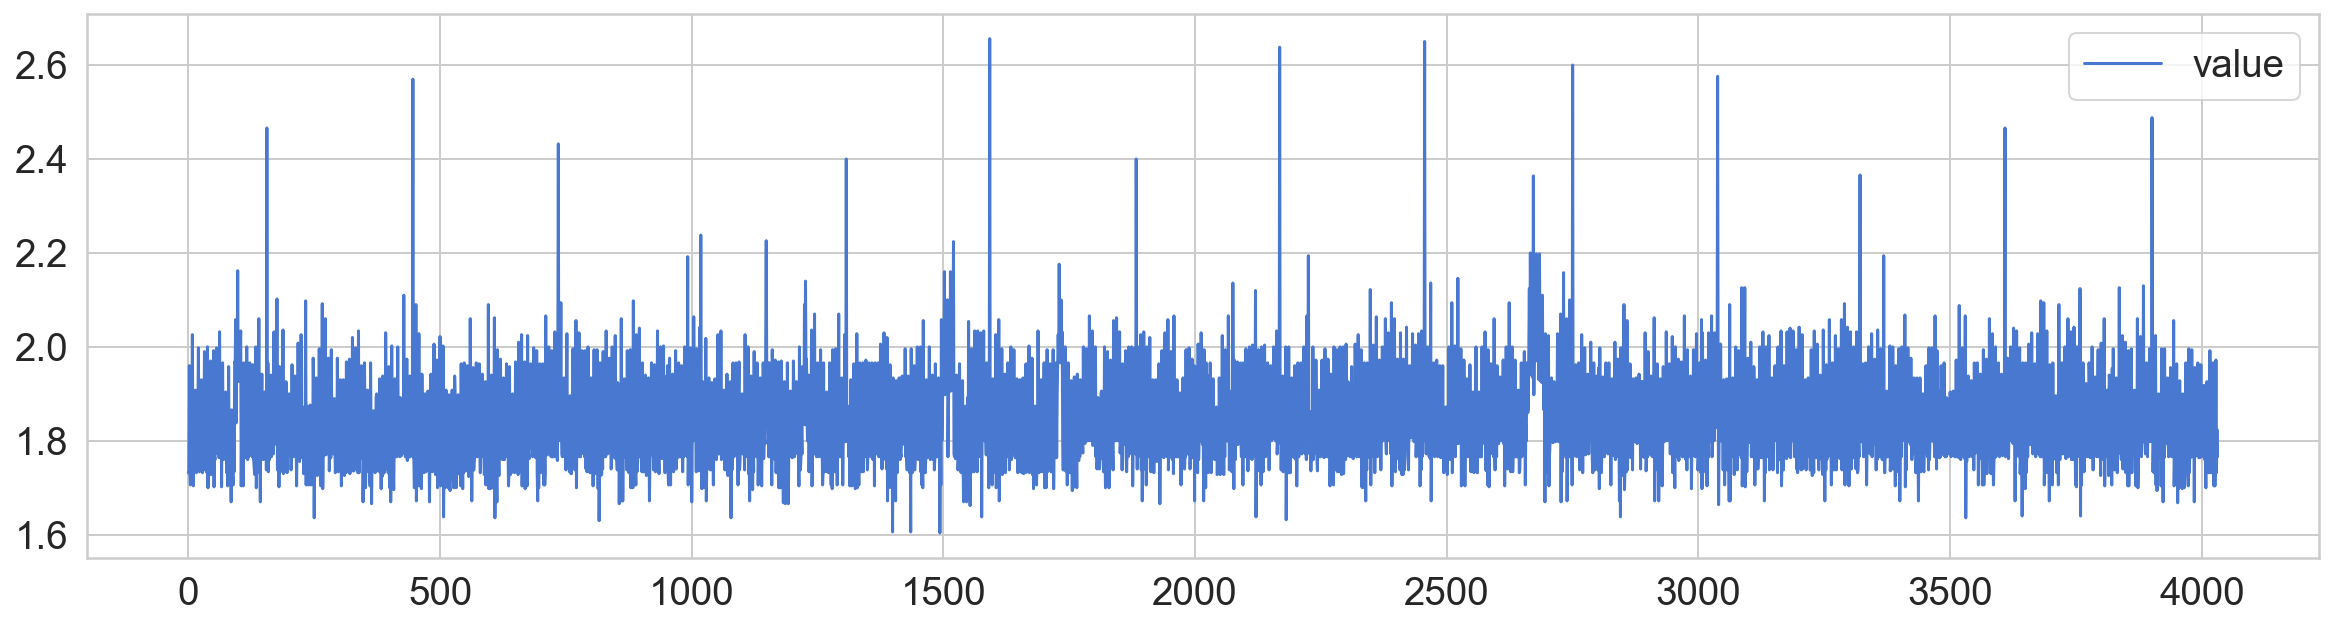

In [5]:
cpu = pd.read_csv('./input/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv')
cpu.plot()

<AxesSubplot:>

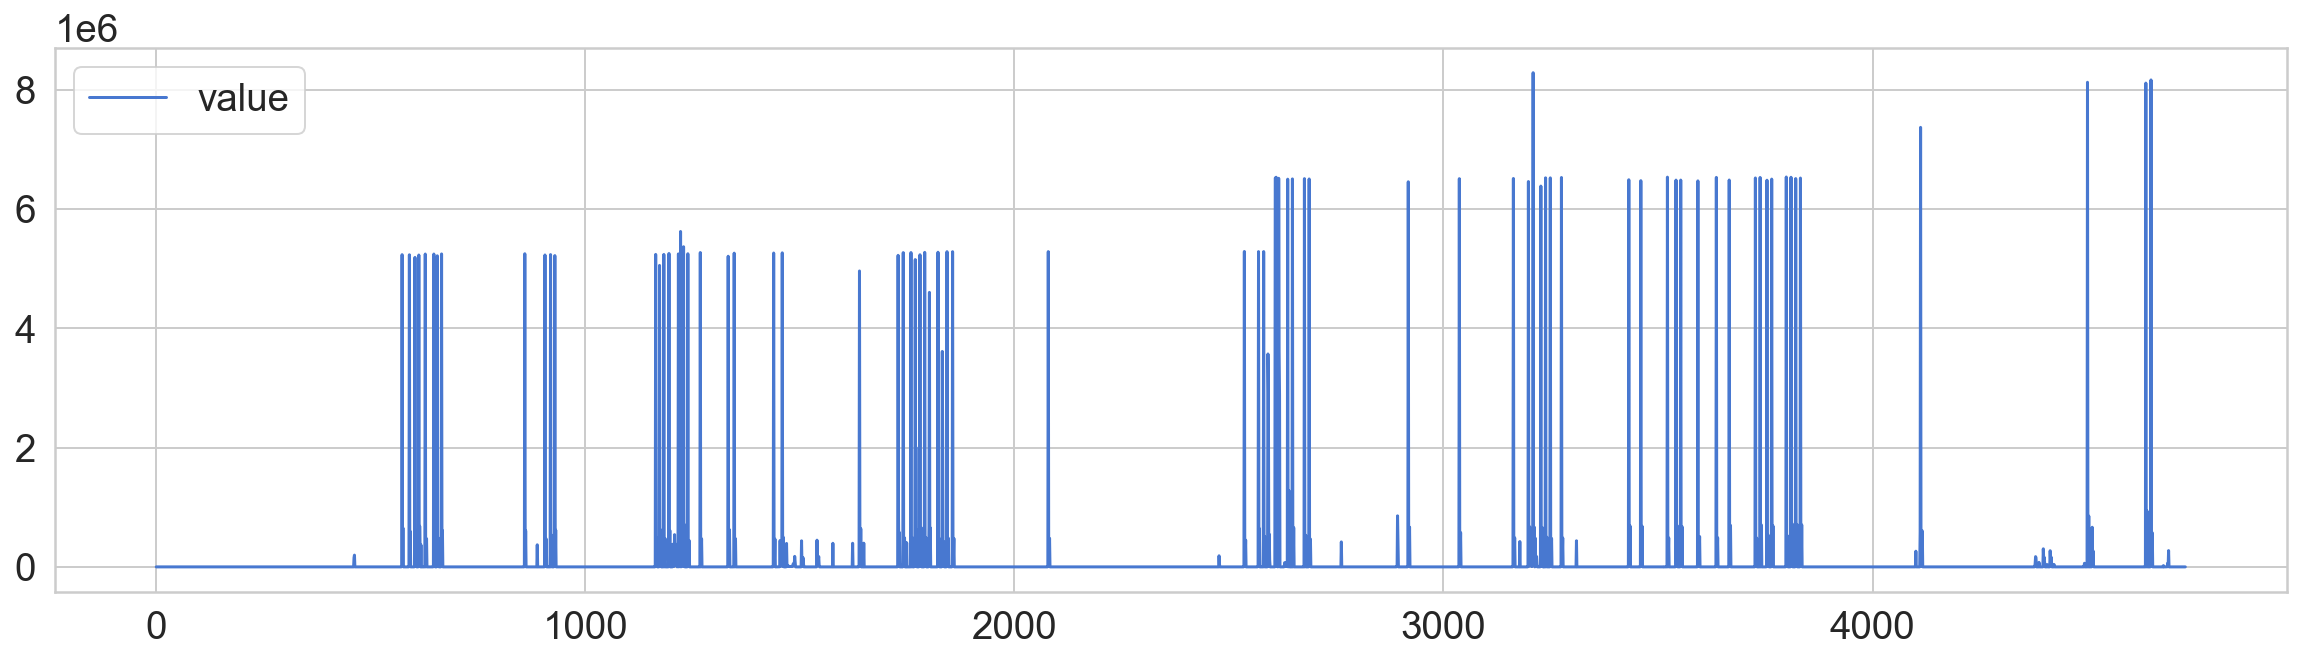

In [6]:
network = pd.read_csv('./input/realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_5abac7.csv')
network.plot()

<AxesSubplot:>

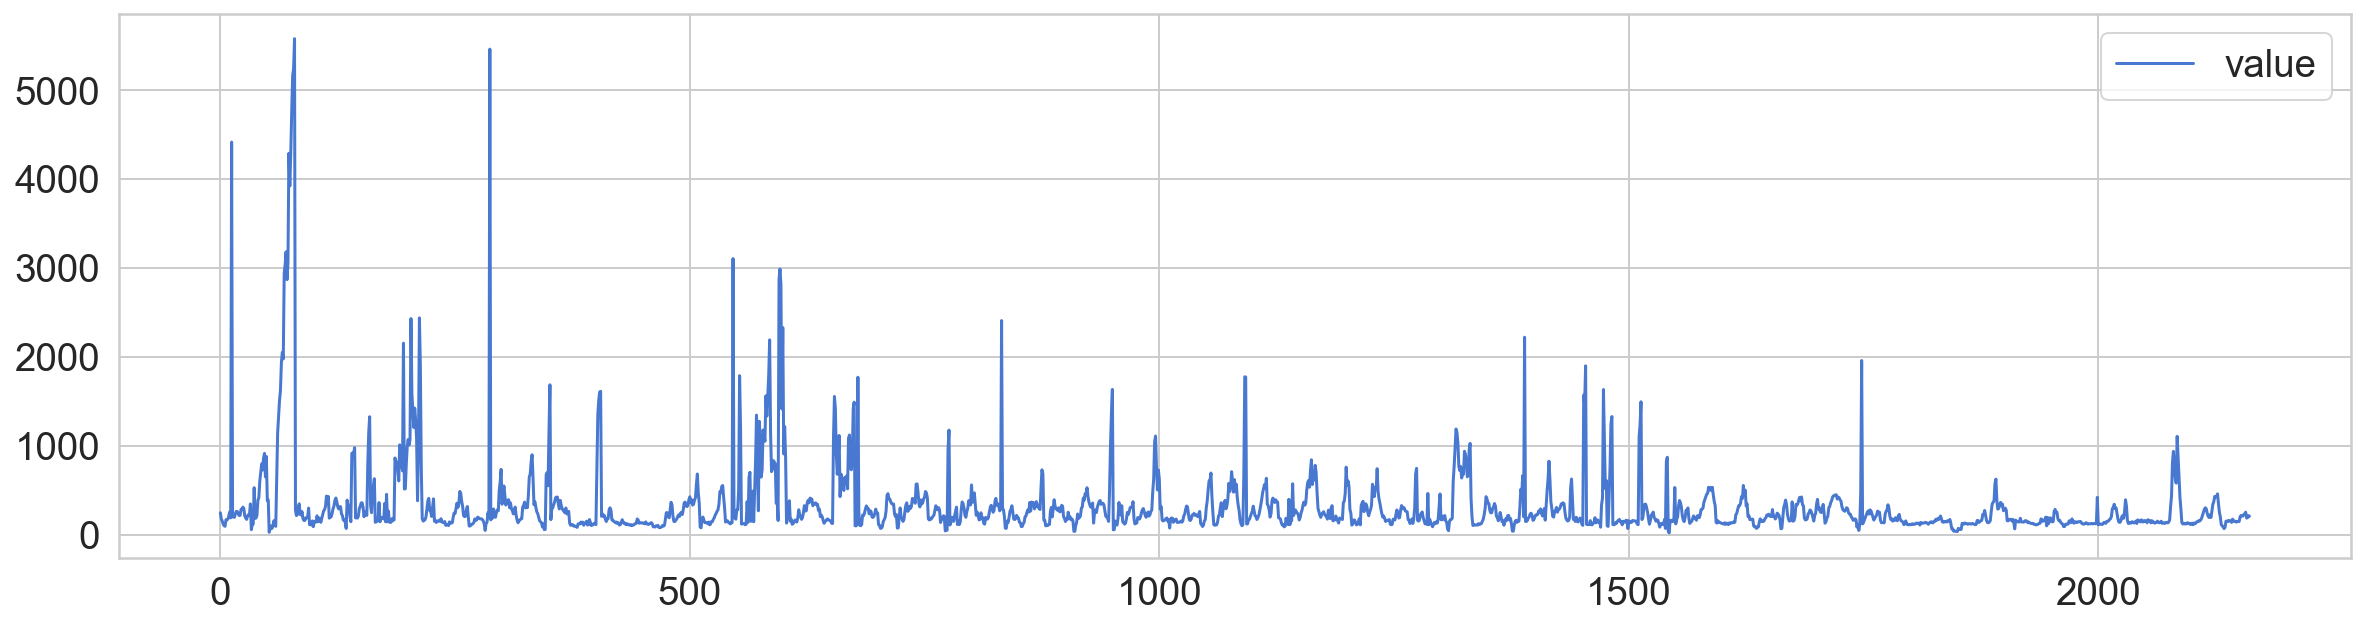

In [7]:
traffic = pd.read_csv('./input/realTraffic/realTraffic/TravelTime_451.csv')
traffic.plot()

<AxesSubplot:>

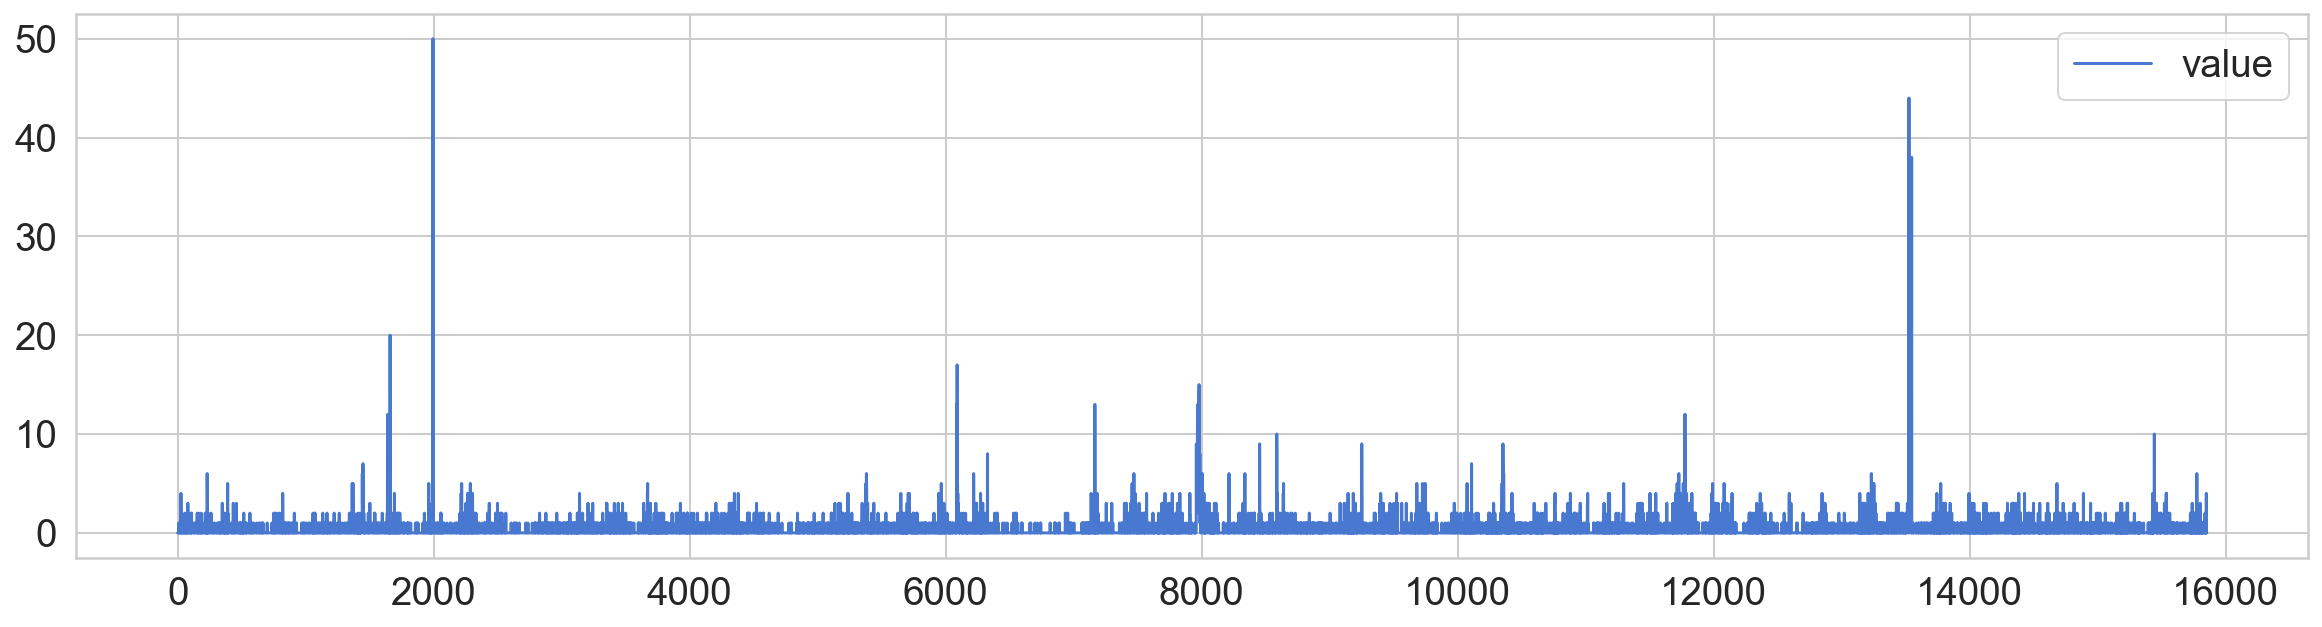

In [8]:
twitter = pd.read_csv('./input/realTweets/realTweets/Twitter_volume_CVS.csv')
twitter.plot()

# Find the anomalies in our data

In [15]:
def plot_anomalies(dfs, algorithm, parameters, title=False, dumping=False):
    '''Plot the Streaming Data (an Anomalies)'''
    n = len(dfs)
    lin, col = 1, 1
    for i in range(1, n+1):
        if lin * col < i:
            if lin == col: col += 1
            else: lin += 1
    # create a subplot
    model_name = algorithm.__name__
    fig, axes = plt.subplots(lin, col, squeeze=False, sharex=False, sharey=False, figsize=(col*20, lin*5))
    fig.suptitle(f'Anomaly Detection - {model_name} ({parameters})')
    xlin, xcol = 0, 0
    for i, df in enumerate(dfs):
        # get data 
        get_timestamp = lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()
        X = df.timestamp.apply(lambda x: int(get_timestamp(x)))
        Y = df.value
        # predict anomalies
        model = algorithm(**parameters)
        preds = [model.detect(i, v, dumping=True) for i, v in zip(X, Y)]
        pred, values, stds = tuple(zip(*preds))
        # plot the results
        af  = pd.DataFrame(data={'x':X, 'value':Y, 'pred':pred})
        af2 = pd.DataFrame(data={'x':X, 'value':values, 'pred':pred, 'std': stds})
        af2['ymin'] = af2['value'] - af2['std']
        af2['ymax'] = af2['value'] + af2['std']
        size = af.pred.astype(int) * 20
        sns.lineplot(ax=axes[xlin, xcol], data=af, x='x', y='value')
        sns.scatterplot(ax=axes[xlin, xcol], data=af, x='x', y='value', hue='pred', s=size)
        if dumping: axes[xlin, xcol].fill_between(af2.x, af2.value, af2.ymax, facecolor='green', alpha=0.2)
        if title: axes[xlin, xcol].set_title(f'{title[i]}')
        # update posix
        xlin += 1
        if xlin == lin: xlin,xcol = 0, xcol+1

    plt.tight_layout()
    plt.show()

In [16]:
class StreamingMovingAverage:
    '''Moving Average algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    def __init__(self, threshold=1.5) -> None:
        # Parameters
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 3
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def detect(self, timestamp: int, value: float, dumping: bool=False) -> bool:
        '''Detect if is a Anomaly'''
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        response, curr_value, deviation = False, value, 0.0
        if self._enough_data() and not np.isnan(expected_value):
            # is the value out of the boundary? when it decrease
            curr_value = expected_value
            deviation = self._standard_deviation() * self.max_deviation_from_expected
            # when it is higher than expected
            if expected_value + deviation < value:
                response = True
        # dumping or not
        if dumping: return (response, curr_value, deviation)
        else: return response

    def _update_state(self, timestamp: int, value: float) -> None:
        '''Update the model state'''
        # check if it is the first time the model is run or if there is a big interval between the timestamps
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # update the model state
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # is there a lot of data? remove one record
        if len(self.data_streaming) > self.max_nof_records_in_model:
            self.data_streaming.pop(0)

    def _init_state(self, timestamp: int) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self.data_streaming = list()

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        data = self.data_streaming
        return np.std(data, axis=0)

    def get_state(self) -> dict:
        '''Get the state'''
        self_dict = {key: value for key, value in self.__dict__.items()}
        return pickle.dumps(self_dict, 4)

    def set_state(self, state) -> None:
        '''Set the state'''
        _self = self
        ad = pickle.loads(state)
        for key, value in ad.items():
            setattr(_self, key, value)

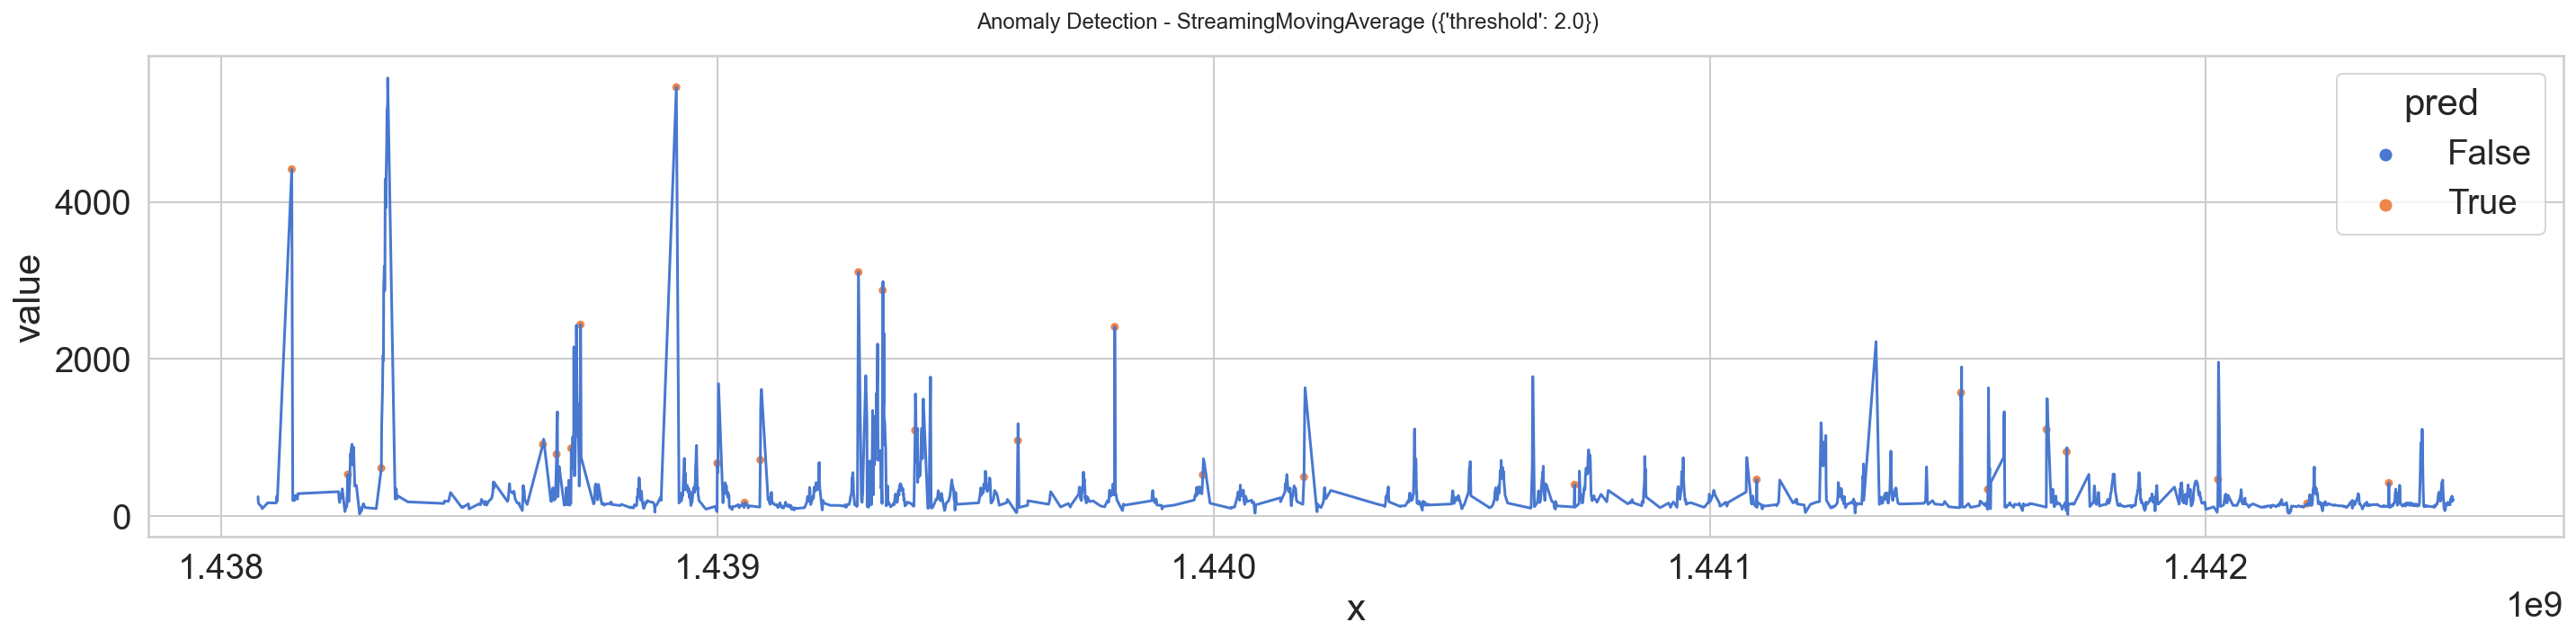

In [19]:
algorithm = StreamingMovingAverage
params = {'threshold': 2.0}
plot_anomalies([traffic], algorithm, params)